In [85]:
import pandas
from scipy.io import arff
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import time
from dl85 import DL85Predictor
from dl85 import DL85Classifier
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

pd.set_option('max_columns', None)

# src: https://www.kaggle.com/hjmjerry/gender-discrimination
df = pandas.read_csv("dataset_perso/Lawsuit.csv")
del df['ID']
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Sal94,Sal95
0,1,1,0,0,7.4,9,3,77836,84612
1,1,1,0,0,6.7,10,2,69994,78497
2,1,1,0,0,8.1,6,1,62872,67756
3,1,1,1,1,5.1,27,3,155196,173220
4,1,1,0,0,7.0,10,3,89268,96099
...,...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,297174,323699
257,6,0,1,1,2.6,9,3,308081,339664
258,6,0,1,1,2.8,8,1,211269,241577
259,6,0,1,1,2.4,2,1,210801,233905


In [86]:
salary_mean = np.mean(np.array(df["Sal94"].tolist(), float))
for i in range(0,len(df)):
    if df.at[i, "Sal94"] >= salary_mean:
        df.at[i, "Salary_mean"] = 1
    else:
        df.at[i, "Salary_mean"] = 0
del df["Sal94"]
del df["Sal95"]
df

,Dept,Gender,Clin,Cert,Prate,Exper,Rank,Salary_mean
0,1,1,0,0,7.4,9,3,0.0
1,1,1,0,0,6.7,10,2,0.0
2,1,1,0,0,8.1,6,1,0.0
3,1,1,1,1,5.1,27,3,1.0
4,1,1,0,0,7.0,10,3,0.0
...,...,...,...,...,...,...,...,...
256,6,0,1,1,2.9,8,2,1.0
257,6,0,1,1,2.6,9,3,1.0
258,6,0,1,1,2.8,8,1,1.0
259,6,0,1,1,2.4,2,1,1.0


In [87]:
col = ['Rank', 'Dept']
df = df.drop(['Prate', 'Exper'], axis=1)
df = pd.get_dummies(df, columns=col)
df


,Gender,Clin,Cert,Salary_mean,Rank_1,Rank_2,Rank_3,Dept_1,Dept_2,Dept_3,Dept_4,Dept_5,Dept_6
0,1,0,0,0.0,0,0,1,1,0,0,0,0,0
1,1,0,0,0.0,0,1,0,1,0,0,0,0,0
2,1,0,0,0.0,1,0,0,1,0,0,0,0,0
3,1,1,1,1.0,0,0,1,1,0,0,0,0,0
4,1,0,0,0.0,0,0,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
256,0,1,1,1.0,0,1,0,0,0,0,0,0,1
257,0,1,1,1.0,0,0,1,0,0,0,0,0,1
258,0,1,1,1.0,1,0,0,0,0,0,0,0,1
259,0,1,1,1.0,1,0,0,0,0,0,0,0,1


In [88]:
X = df.loc[:, ~df.columns.isin(['Gender', 'Salary_mean'])]
y = df['Salary_mean']
sensitive = df['Gender']

def train_test_split(random_state):
    global X_train, y_train, sensitive_train
    global X_test, y_test, sensitive_test


    index_train = list(df.sample(frac=0.8, random_state=random_state).index)
    index_test = list(df.drop(index=index_train).index)

    X_train = X.drop(index=index_test).to_numpy()
    y_train = y.drop(index=index_test).to_numpy()
    sensitive_train = sensitive.drop(index=index_test).to_numpy()

    X_test = X.drop(index=index_train).to_numpy()
    y_test = list(y.drop(index=index_train).to_numpy())
    sensitive_test = sensitive.drop(index=index_train).to_numpy()
train_test_split(1)

In [89]:
def descr_clf(sensit, y):
    """
    p0: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0, clf(𝑥) = +}∣
    p1: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1, clf(𝑥) = +}∣
    n_zero: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0}∣
    n_one: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1}∣
    """
    p0, p1, n_zero, n_one= 0, 0, 0, 0
    for i in range(0, len(y)):
        if sensit[i] == 0.0:
            n_zero+=1
            if y[i] == 1.0:
                p0+=1
        elif sensit[i] == 1.0:
            n_one+=1
            if y[i] == 1.0:
                p1+=1

    if n_one == 0 and n_zero == 0: d = 0
    elif n_zero == 0: d = -(p1/n_one)
    elif n_one == 0: d = p0/n_zero
    else: d = (p0/n_zero) - (p1/n_one)

    #A higher discrimination means that tuples with
    #Sensitive = 1 are less likely to be classified as positive
    return d

def descr(tids):
    """
    p0: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0, 𝑥.Class = +}∣
    p1: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1, 𝑥.Class = +}∣
    n_zero: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0}∣
    n_one: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1}∣
    """
    p0, p1, n_zero, n_one= 0, 0, 0, 0
    for i in tids:
        if sensitive_train[i] == 0.0:
            n_zero+=1
            if y_train[i] == 1.0:
                p0+=1
        elif sensitive_train[i] == 1.0:
            n_one+=1
            if y_train[i] == 1.0:
                p1+=1

    if n_one == 0 and n_zero == 0: d = 0
    elif n_zero == 0: d = -(p1/n_one)
    elif n_one == 0: d = p0/n_zero
    else: d = (p0/n_zero) - (p1/n_one)

    #A higher discrimination means that tuples with
    #Sensitive = 1 are less likely to be classified as positive
    return d

def descr_add(tids):
    """
    p0: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0, 𝑥.Class = +}∣
    p1: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1, 𝑥.Class = +}∣
    n_zero: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 0}∣
    n_one: ∣{𝑥 ∈ 𝐷 ∣ 𝑥.Sensitive = 1}∣
    """
    p0, p1 = 0, 0
    for i in tids:
        if sensitive_train[i] == 0.0:
            if y_train[i] == 1.0:
                p0+=1
        elif sensitive_train[i] == 1.0:
            if y_train[i] == 1.0:
                p1+=1

    cnt = np.unique(sensitive_train, return_counts=True)[1]
    n_zero = cnt[0]
    n_one = cnt[1]

    if n_one == 0 and n_zero == 0: d = 0
    elif n_zero == 0: d = -(p1/n_one)
    elif n_one == 0: d = p0/n_zero
    else: d = (p0/n_zero) - (p1/n_one)

    #A higher discrimination means that tuples with
    #Sensitive = 1 are less likely to be classified as positive
    return d

def error(tids):
    classes, supports = np.unique(y_train.take(tids), return_counts=True)
    maxindex = np.argmax(supports)

    return sum(supports) - supports[maxindex], classes[maxindex]

def error1(tids, k=1):
    classes, supports = np.unique(y_train.take(tids), return_counts=True)
    maxindex = np.argmax(supports)

    return sum(supports) - supports[maxindex] + (sum(supports) - supports[maxindex]) * abs(descr_add(tids)) * k, classes[maxindex]

def error2(tids, k=1):
    classes, supports = np.unique(y_train.take(tids), return_counts=True)
    maxindex = np.argmax(supports)

    return sum(supports) - supports[maxindex] + abs(descr_add(tids)) * k, classes[maxindex]

def error3(tids, k=1000):
    classes, supports = np.unique(y_train.take(list(tids)), return_counts=True)
    maxindex = np.argmax(supports)

    return sum(supports) - supports[maxindex] + abs(descr_add(tids)) * k, classes[maxindex]

def error4(tids):
    classes, supports = np.unique(y_train.take(list(tids)), return_counts=True)
    maxindex = np.argmax(supports)
    #print(f'{supports[maxindex] / sum(supports)} {abs(descr(tids))}')
    return abs(descr_add(tids)), classes[maxindex]


descr(range(0,len(X_train)))


-0.32561904761904764

In [90]:
result = pd.DataFrame(columns=['function', 'depth', 'clf.accuracy_', 'accuracy_train', "accuracy_test", 'discrimination_train', 'discrimination_test', "duration", "min_supp", "random_state"])

In [91]:
#for supp in range(1, len(X_train), int(len(X_train)/10)):

for depth in range(1, 8):
    #for min_supp in range(1, len(X_train), int(len(X_train)/4)):
    for min_supp in range(1,2):
        for random_state in range(1, 51, 5):
            train_test_split(random_state)

            clf = DL85Classifier(max_depth=depth, error_function=lambda tids: error(list(tids)), min_sup=min_supp, time_limit=600)
            print(f"### Depth: {depth} state: {random_state} error ###")
            start = time.perf_counter()
            print(f"Model building...")
            clf.fit(X_train, list(y_train))
            duration = time.perf_counter() - start
            print("Model built. Duration of building =", round(duration, 4))
            y_pred = clf.predict(X_train)
            accuracy_train = round(accuracy_score(list(y_train), y_pred), 4)
            print("Accuracy", accuracy_train)
            print("Accuracy DL8.5 on training set =", round(clf.accuracy_, 4))
            y_pred_test = clf.predict(X_test)
            accuracy_test = round(accuracy_score(y_test, y_pred_test), 4)
            print("Accuracy DL8.5 on test set =", accuracy_test)
            descrimation_test = round(descr_clf(sensitive_test, y_pred_test), 4)
            print("Discrimination of classifier", round(descr_clf(sensitive_test, y_pred_test), 4))
            y_pred_train = clf.predict(X_train)
            accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
            print("Accuracy DL8.5 on test set =", accuracy_train)
            descrimation_train = round(descr_clf(sensitive_train, y_pred_train), 4)
            print("Discrimination of classifier", round(descr_clf(sensitive_train, y_pred_train), 4))
            print(f"error: {clf.error_}")

            result.loc[len(result.index)] = ["error", depth, clf.accuracy_, accuracy_train, accuracy_test, abs(descrimation_train), abs(descrimation_test), duration, min_supp, random_state]

            print()

            clf = DL85Classifier(max_depth=depth, error_function=lambda tids: error1(list(tids)), min_sup=min_supp, time_limit=600)
            print(f"### Depth: {depth} state: {random_state} error1 ###")
            start = time.perf_counter()
            print(f"Model building...")
            clf.fit(X_train, list(y_train))
            duration = time.perf_counter() - start
            print("Model built. Duration of building =", round(duration, 4))
            y_pred_test = clf.predict(X_test)
            accuracy_test = round(accuracy_score(y_test, y_pred_test), 4)
            print("Accuracy DL8.5 on test set =", accuracy_test)
            descrimation_test = round(descr_clf(sensitive_test, y_pred_test), 4)
            print("Discrimination of classifier", round(descr_clf(sensitive_test, y_pred_test), 4))
            y_pred_train = clf.predict(X_train)
            accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
            print("Accuracy DL8.5 on test set =", accuracy_train)
            descrimation_train = round(descr_clf(sensitive_train, y_pred_train), 4)
            print("Discrimination of classifier", round(descr_clf(sensitive_train, y_pred_train), 4))
            print(f"error: {clf.error_}")

            result.loc[len(result.index)] = ["error1", depth, clf.accuracy_, accuracy_train, accuracy_test, abs(descrimation_train), abs(descrimation_test), duration, min_supp, random_state]

            print()

            clf = DL85Classifier(max_depth=depth, error_function=lambda tids: error2(list(tids)), min_sup=min_supp, time_limit=600)
            print(f"### Depth: {depth} state: {random_state} error2 ###")
            start = time.perf_counter()
            print(f"Model building...")
            clf.fit(X_train, list(y_train))
            duration = time.perf_counter() - start
            print("Model built. Duration of building =", round(duration, 4))
            y_pred_test = clf.predict(X_test)
            accuracy_test = round(accuracy_score(y_test, y_pred_test), 4)
            print("Accuracy DL8.5 on test set =", accuracy_test)
            descrimation_test = round(descr_clf(sensitive_test, y_pred_test), 4)
            print("Discrimination of classifier", round(descr_clf(sensitive_test, y_pred_test), 4))
            y_pred_train = clf.predict(X_train)
            accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
            print("Accuracy DL8.5 on test set =", accuracy_train)
            descrimation_train = round(descr_clf(sensitive_train, y_pred_train), 4)
            print("Discrimination of classifier", round(descr_clf(sensitive_train, y_pred_train), 4))
            print(f"error: {clf.error_}")

            result.loc[len(result.index)] = ["error2", depth, clf.accuracy_, accuracy_train, accuracy_test, abs(descrimation_train), abs(descrimation_test), duration, min_supp, random_state]

            print()

            clf = DL85Classifier(max_depth=depth, error_function=lambda tids: error3(list(tids)), min_sup=min_supp, time_limit=600)
            print(f"### Depth: {depth} state: {random_state} error3 ###")
            start = time.perf_counter()
            print(f"Model building...")
            clf.fit(X_train, list(y_train))
            duration = time.perf_counter() - start
            print("Model built. Duration of building =", round(duration, 4))
            y_pred_test = clf.predict(X_test)
            accuracy_test = round(accuracy_score(y_test, y_pred_test), 4)
            print("Accuracy DL8.5 on test set =", accuracy_test)
            descrimation_test = round(descr_clf(sensitive_test, y_pred_test), 4)
            print("Discrimination of classifier", round(descr_clf(sensitive_test, y_pred_test), 4))
            y_pred_train = clf.predict(X_train)
            accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
            print("Accuracy DL8.5 on test set =", accuracy_train)
            descrimation_train = round(descr_clf(sensitive_train, y_pred_train), 4)
            print("Discrimination of classifier", round(descr_clf(sensitive_train, y_pred_train), 4))
            print(f"error: {clf.error_}")

            result.loc[len(result.index)] = ["error3", depth, clf.accuracy_, accuracy_train, accuracy_test, abs(descrimation_train), abs(descrimation_test), duration, min_supp, random_state]

            print()

            clf = DL85Classifier(max_depth=depth, error_function=lambda tids: error4(list(tids)), min_sup=min_supp, time_limit=600)
            print(f"### Depth: {depth} state: {random_state} error4 ###")
            start = time.perf_counter()
            print(f"Model building...")
            clf.fit(X_train, list(y_train))
            duration = time.perf_counter() - start
            print("Model built. Duration of building =", round(duration, 4))
            y_pred_test = clf.predict(X_test)
            accuracy_test = round(accuracy_score(y_test, y_pred_test), 4)
            print("Accuracy DL8.5 on test set =", accuracy_test)
            descrimation_test = round(descr_clf(sensitive_test, y_pred_test), 4)
            print("Discrimination of classifier", round(descr_clf(sensitive_test, y_pred_test), 4))
            y_pred_train = clf.predict(X_train)
            accuracy_train = round(accuracy_score(y_train, y_pred_train), 4)
            print("Accuracy DL8.5 on test set =", accuracy_train)
            descrimation_train = round(descr_clf(sensitive_train, y_pred_train), 4)
            print("Discrimination of classifier", round(descr_clf(sensitive_train, y_pred_train), 4))
            print(f"error: {clf.error_}")

            result.loc[len(result.index)] = ["error4", depth, clf.accuracy_, accuracy_train, accuracy_test, abs(descrimation_train), abs(descrimation_test), duration, min_supp, random_state]

            print()

### Depth: 1 state: 1 error ###
Model building...
Model built. Duration of building = 0.0043
Accuracy 0.756
Accuracy DL8.5 on training set = 0.756
Accuracy DL8.5 on test set = 0.7308
Discrimination of classifier -0.2667
Accuracy DL8.5 on test set = 0.756
Discrimination of classifier -0.1565
error: 51.0

### Depth: 1 state: 1 error1 ###
Model building...
Model built. Duration of building = 0.0166
Accuracy DL8.5 on test set = 0.7308
Discrimination of classifier -0.2667
Accuracy DL8.5 on test set = 0.756
Discrimination of classifier -0.1565
error: 59.626286

### Depth: 1 state: 1 error2 ###
Model building...
Model built. Duration of building = 0.0165
Accuracy DL8.5 on test set = 0.7308
Discrimination of classifier -0.2667
Accuracy DL8.5 on test set = 0.756
Discrimination of classifier -0.1565
error: 51.325619

### Depth: 1 state: 1 error3 ###
Model building...
Model built. Duration of building = 0.0157
Accuracy DL8.5 on test set = 0.7308
Discrimination of classifier -0.2667
Accuracy DL8.5

In [92]:
result = result.sort_values(['function', 'depth', 'min_supp'])
result

,function,depth,clf.accuracy_,accuracy_train,accuracy_test,discrimination_train,discrimination_test,duration,min_supp,random_state
0,error,1,0.755981,0.7560,0.7308,0.1565,0.2667,0.004288,1,1
5,error,1,0.741627,0.7416,0.7885,0.1437,0.3214,0.005333,1,6
10,error,1,0.755981,0.7560,0.7308,0.1772,0.1822,0.002405,1,11
15,error,1,0.746411,0.7464,0.7692,0.1746,0.2059,0.003582,1,16
20,error,1,0.736842,0.7368,0.8077,0.1465,0.3072,0.002455,1,21
...,...,...,...,...,...,...,...,...,...,...
329,error4,7,0.998651,0.8134,0.7308,0.0372,0.3693,2.701160,1,26
334,error4,7,0.998371,0.7990,0.7885,0.1421,0.0694,2.680032,1,31
339,error4,7,0.998716,0.8565,0.7885,0.1632,0.1843,2.591844,1,36
344,error4,7,0.998723,0.8230,0.7692,0.1108,0.1850,2.729622,1,41


# With random_state=1

In [93]:
import matplotlib.pyplot as plt
import numpy as np


def print_plot(x_axe, y_axe, r):
    name = "error"
    name1 = "error1"
    name2 = "error2"
    name3 = "error3"
    name4 = "error4"

    #result = r.loc[r['depth'] == 1]

    plt.figure(figsize= (9, 6))
    result = r.loc[r["random_state"] == 1]
    result = result.loc[result["min_supp"] == 1]
    df1 = result.loc[(result['function'] == "no")]
    #plt.plot(df1[x_axe].tolist(), df1[y_axe].tolist(), label = name_no)
    plt.plot(result.loc[result['function'] == name][x_axe].tolist(), result.loc[result['function'] == name][y_axe].tolist(), label = name, linestyle="dotted")
    plt.plot(result.loc[result['function'] == name1][x_axe].tolist(), result.loc[result['function'] == name1][y_axe].tolist(), label = name1, linestyle="--")
    plt.plot(result.loc[result['function'] == name2][x_axe].tolist(), result.loc[result['function'] == name2][y_axe].tolist(), label = name2, linestyle="-.")
    plt.plot(result.loc[result['function'] == name3][x_axe].tolist(), result.loc[result['function'] == name3][y_axe].tolist(), label = name3, linestyle=":")
    plt.plot(result.loc[result['function'] == name4][x_axe].tolist(), result.loc[result['function'] == name4][y_axe].tolist(), label = name3)


    plt.xlabel(x_axe)
    plt.ylabel(y_axe)
    plt.legend()

    plt.show()


In [94]:
#print_plot("depth", "discrimination_train", result)

In [95]:
#print_plot("depth", "discrimination_test", result)

In [96]:
#print_plot("depth", "accuracy_train", result)

In [97]:
#print_plot("depth", "accuracy_test", result)

In [98]:
#print_plot("accuracy_train", "accuracy_train", result)

In [99]:
#print_plot("accuracy_test", "accuracy_train", result)

# Mean of random_state

In [115]:
def print_plot_mean(x_axe, y_axe, r):
    plt.figure(figsize= (9, 6))
    r = r.loc[r["min_supp"] == 1]
    for function in [ "error", "error1", "error2", "error3", "error4"]:
        x_values = list()
        y_values = list()

        for depth in r['depth'].unique():
            df1 = r.loc[(r["function"] == function) & (r["depth"] == depth)]
            y_values.append(df1[y_axe].mean())

        plt.plot(r['depth'].unique(), y_values, label = function)

    plt.xlabel(x_axe)
    plt.ylabel(y_axe)
    plt.legend()

    plt.show()


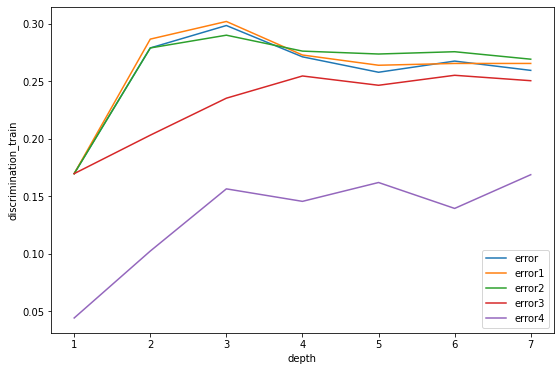

In [116]:
print_plot_mean("depth", "discrimination_train", result)

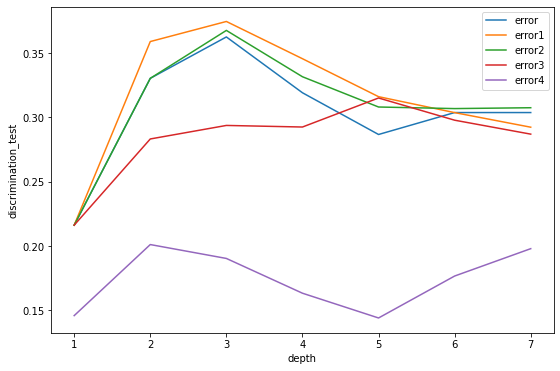

In [117]:
print_plot_mean("depth", "discrimination_test", result)

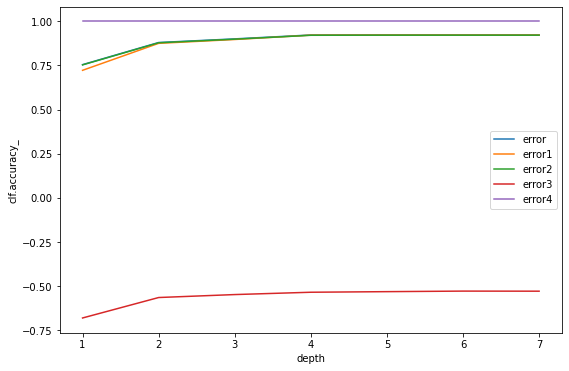

In [103]:
print_plot_mean("depth", "clf.accuracy_", result)

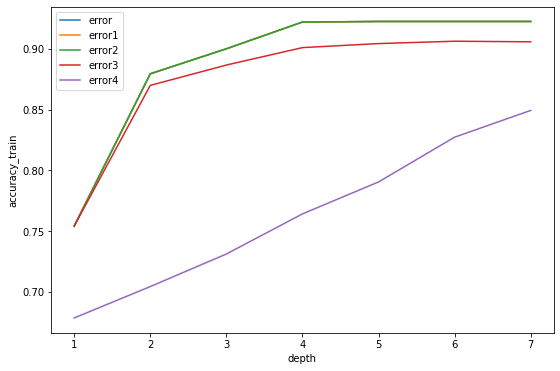

In [104]:
print_plot_mean("depth", "accuracy_train", result)

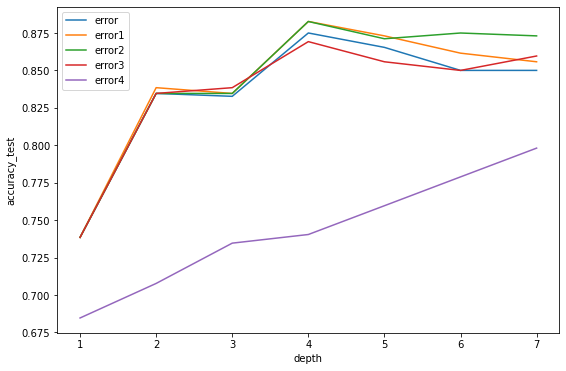

In [105]:
print_plot_mean("depth", "accuracy_test", result)

In [106]:
def print_plot(x_axe, y_axe, r):
    plt.figure(figsize= (9, 6))
    r = r.loc[r["min_supp"] == 1]
    for function in ["error", "error1", "error2", "error3", "error4"]:
        x_values = list()
        y_values = list()

        for depth in r['depth'].unique():
            df1 = r.loc[(r["function"] == function) & (r["depth"] == depth)]
            y_values.append(df1[y_axe].mean())
            x_values.append(df1[x_axe].mean())
        plt.plot(x_values, y_values, label = function)

    plt.xlabel(x_axe)
    plt.ylabel(y_axe)
    plt.legend()

    plt.show()

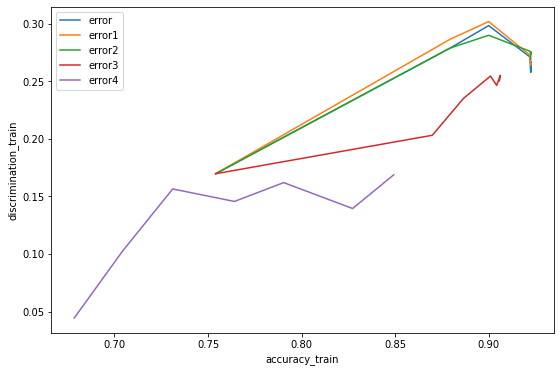

In [107]:
print_plot("accuracy_train", "discrimination_train", result)

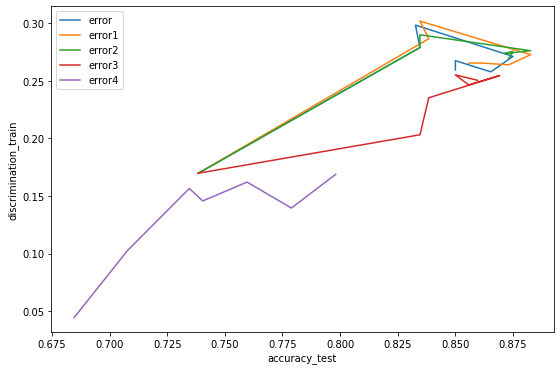

In [108]:
print_plot("accuracy_test", "discrimination_train", result)

In [109]:
from pprint import pprint

clf = DL85Classifier(max_depth=7, error_function=lambda tids: error(list(tids)), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
pprint(clf.tree_)

{'feat': 0,
 'left': {'feat': 1,
          'left': {'feat': 2,
                   'left': {'feat': 5,
                            'left': {'error': 0.0,
                                     'proba': [1.0, 0],
                                     'value': 0},
                            'proba': [0.42, 0.58],
                            'right': {'feat': 6,
                                      'left': {'error': 0.0,
                                               'proba': [1.0, 0],
                                               'value': 0},
                                      'proba': [0.40816326530612246,
                                                0.5918367346938775],
                                      'right': {'feat': 7,
                                                'left': {'error': 0.0,
                                                         'proba': [1.0, 0],
                                                         'value': 0},
                                        

In [110]:
import graphviz
# print the tree
dot = clf.export_graphviz()
graph = graphviz.Source(dot, format="png")
graph.render("plots/lawsuit")

'plots/lawsuit.png'

In [111]:
clf = DL85Classifier(max_depth=7, error_function=lambda tids: error2(list(tids)), min_sup=1, time_limit=600)
clf.fit(X_train, list(y_train))
pprint(clf.tree_)

{'feat': 0,
 'left': {'feat': 7,
          'left': {'feat': 1,
                   'left': {'feat': 2,
                            'left': {'error': 0.0,
                                     'proba': [1.0, 0],
                                     'value': 0},
                            'proba': [0.4, 0.6],
                            'right': {'feat': 3,
                                      'left': {'error': 0.0,
                                               'proba': [1.0, 0],
                                               'value': 0},
                                      'proba': [0.25, 0.75],
                                      'right': {'error': 0.02459,
                                                'proba': [0, 1.0],
                                                'value': 1}}},
                   'proba': [0.7, 0.3],
                   'right': {'error': 0.0, 'proba': [1.0, 0], 'value': 0}},
          'proba': [0.4, 0.6],
          'right': {'feat': 6,
                    '

In [112]:
import graphviz
# print the tree
dot = clf.export_graphviz()
graph = graphviz.Source(dot, format="png")
graph.render("plots/lawsuit2")

'plots/lawsuit2.png'